# Exploratory Data Analysis: Legal Text Readability Classification

**Objective:** Analyze legal text documents to understand patterns in readability and prepare for building a classifier.

**Dataset:** Hungarian legal documents (terms of service, legal agreements) labeled on a 5-point readability scale.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the preprocessed dataset
with open('../data/dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

print(f"Dataset loaded: {len(df):,} documents")
print(f"Columns: {list(df.columns)}")
df.head(3)

Dataset loaded: 4,661 documents
Columns: ['id', 'subdirectory', 'filename', 'line_number', 'content', 'label', 'label_metadata']


,id,subdirectory,filename,line_number,content,label,label_metadata
0,0,FA0B9B,volan_aszf,1,Szolgáltató a közforgalmú menetrend szerinti j...,2-Nehezen érthető,"{'label_id': 68, 'file_upload': 'a44b274a-vola..."
1,1,FA0B9B,volan_aszf,2,az Európai Parlament és a Tanács (EU) 2016/679...,2-Nehezen érthető,"{'label_id': 69, 'file_upload': 'a44b274a-vola..."
2,2,FA0B9B,volan_aszf,3,Teljesárú menetjegy megvásárlásával megkötött ...,3-Többé/kevésbé megértem,"{'label_id': 70, 'file_upload': 'a44b274a-vola..."


## 2. Dataset Overview

In [3]:
# Basic statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total documents: {len(df):,}")
print(f"Labeled documents: {df['label'].notna().sum():,} ({df['label'].notna().sum()/len(df)*100:.2f}%)")
print(f"Unlabeled documents: {df['label'].isna().sum():,} ({df['label'].isna().sum()/len(df)*100:.2f}%)")
print(f"\nUnique subdirectories: {df['subdirectory'].nunique()}")
print(f"Unique source files: {df['filename'].nunique()}")

# Check for imputed labels
df['is_imputed'] = df['label_metadata'].apply(
    lambda x: x.get('imputed', False) if isinstance(x, dict) else False
)
imputed_count = df['is_imputed'].sum()
print(f"\nImputed labels (from consensus): {imputed_count:,}")
print(f"Original labels: {df['label'].notna().sum() - imputed_count:,}")

DATASET OVERVIEW
Total documents: 4,661
Labeled documents: 3,560 (76.38%)
Unlabeled documents: 1,101 (23.62%)

Unique subdirectories: 30
Unique source files: 56

Imputed labels (from consensus): 186
Original labels: 3,374


In [4]:
# Data types and missing values
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4661 entries, 0 to 4660
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              4661 non-null   int64 
 1   subdirectory    4661 non-null   object
 2   filename        4661 non-null   object
 3   line_number     4661 non-null   int64 
 4   content         4661 non-null   object
 5   label           3560 non-null   object
 6   label_metadata  3686 non-null   object
 7   is_imputed      4661 non-null   bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 259.6+ KB


## 3. Label Distribution Analysis

Understanding the distribution of readability labels is crucial for classification.

In [5]:
# Filter labeled data only
df_labeled = df[df['label'].notna()].copy()

print(f"Working with {len(df_labeled):,} labeled documents\n")

# Label distribution
label_counts = df_labeled['label'].value_counts().sort_index()
print("Label Distribution:")
print("=" * 60)
for label, count in label_counts.items():
    pct = count / len(df_labeled) * 100
    print(f"{label:30s}: {count:5d} ({pct:5.2f}%)")
print("=" * 60)

Working with 3,560 labeled documents

Label Distribution:
1-Nagyon nehezen érthető      :   188 ( 5.28%)
2-Nehezen érthető             :   382 (10.73%)
3-Többé/kevésbé megértem      :   727 (20.42%)
4-Érthető                     :  1106 (31.07%)
5-Könnyen érthető             :  1157 (32.50%)


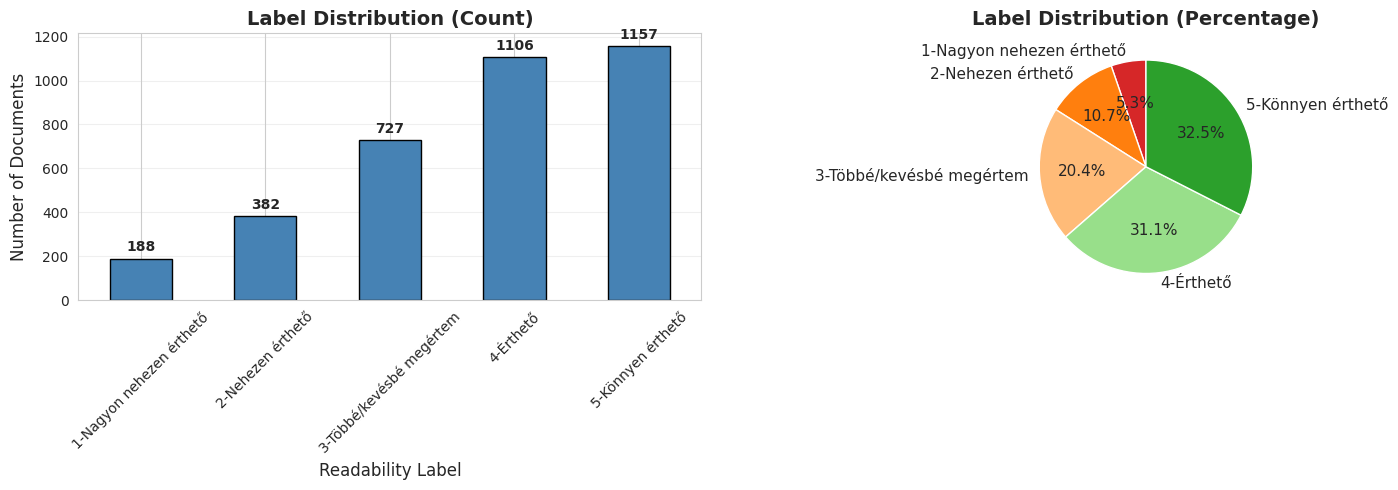


Class Balance Analysis:
Most common class: 5-Könnyen érthető (1157 samples)
Least common class: 1-Nagyon nehezen érthető (188 samples)
Imbalance ratio: 6.15:1


In [7]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
label_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Readability Label', fontsize=12)
axes[0].set_ylabel('Number of Documents', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c']
label_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                  colors=colors, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Class balance analysis
print("\nClass Balance Analysis:")
max_class = label_counts.max()
min_class = label_counts.min()
imbalance_ratio = max_class / min_class
print(f"Most common class: {label_counts.idxmax()} ({max_class} samples)")
print(f"Least common class: {label_counts.idxmin()} ({min_class} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

## 4. Text Content Analysis

Analyzing text characteristics that might correlate with readability.

In [8]:
# Calculate text statistics
df_labeled['text_length'] = df_labeled['content'].str.len()
df_labeled['word_count'] = df_labeled['content'].str.split().str.len()
df_labeled['avg_word_length'] = df_labeled['content'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
)
df_labeled['sentence_count'] = df_labeled['content'].str.count(r'[.!?]') + 1
df_labeled['avg_sentence_length'] = df_labeled['word_count'] / df_labeled['sentence_count']

print("Text Statistics Summary:")
print("=" * 60)
print(df_labeled[['text_length', 'word_count', 'avg_word_length', 
                   'sentence_count', 'avg_sentence_length']].describe())

Text Statistics Summary:
       text_length   word_count  avg_word_length  sentence_count  \
count  3560.000000  3560.000000      3560.000000     3560.000000   
mean    386.823596    48.170506         7.116223        4.591854   
std     369.444567    45.937646         0.861371        3.194455   
min       2.000000     1.000000         2.000000        1.000000   
25%     165.000000    20.000000         6.571429        2.000000   
50%     303.000000    37.000000         7.073622        4.000000   
75%     489.000000    61.000000         7.600000        6.000000   
max    5838.000000   703.000000        13.500000       37.000000   

       avg_sentence_length  
count          3560.000000  
mean             10.986460  
std               7.499319  
min               0.500000  
25%               6.000000  
50%               9.500000  
75%              14.500000  
max             149.333333  



Text Statistics by Readability Label:
                          text_length  word_count  avg_word_length  \
label                                                                
1-Nagyon nehezen érthető       744.79       92.61             7.16   
2-Nehezen érthető              611.33       75.36             7.15   
3-Többé/kevésbé megértem       459.26       56.98             7.18   
4-Érthető                      386.47       48.17             7.14   
5-Könnyen érthető              209.35       26.43             7.04   

                          avg_sentence_length  
label                                          
1-Nagyon nehezen érthető                12.91  
2-Nehezen érthető                       13.26  
3-Többé/kevésbé megértem                12.52  
4-Érthető                               11.59  
5-Könnyen érthető                        8.38  


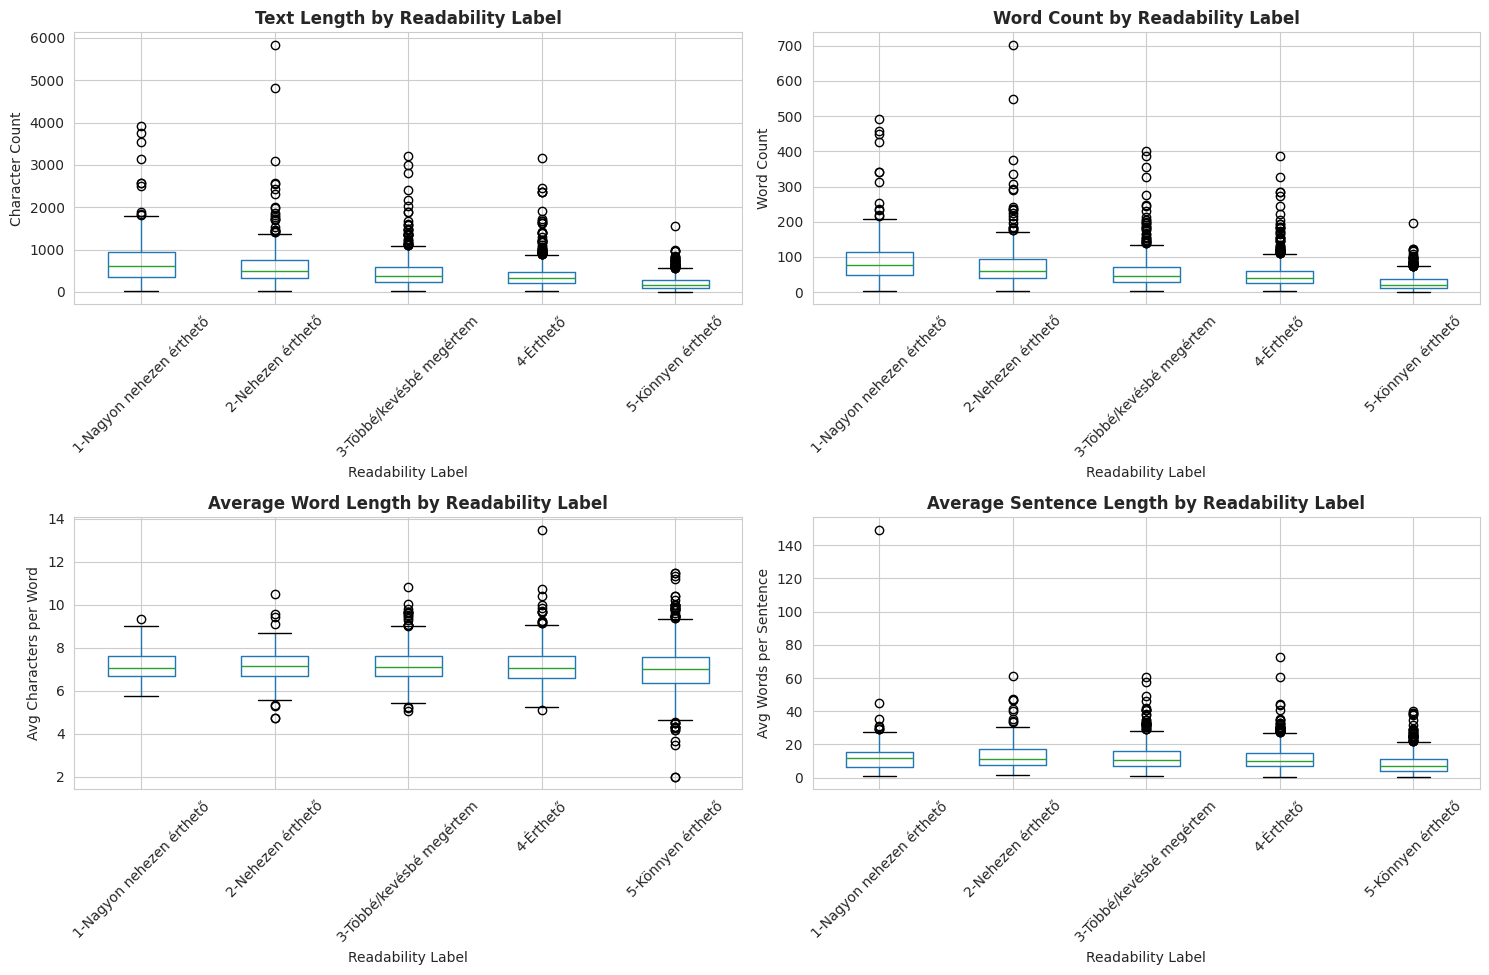

In [9]:
# Text statistics by label
print("\nText Statistics by Readability Label:")
print("=" * 80)

stats_by_label = df_labeled.groupby('label')[['text_length', 'word_count', 
                                                'avg_word_length', 'avg_sentence_length']].mean()
print(stats_by_label.round(2))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length by label
df_labeled.boxplot(column='text_length', by='label', ax=axes[0, 0])
axes[0, 0].set_title('Text Length by Readability Label', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Readability Label')
axes[0, 0].set_ylabel('Character Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=45)

# Word count by label
df_labeled.boxplot(column='word_count', by='label', ax=axes[0, 1])
axes[0, 1].set_title('Word Count by Readability Label', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Readability Label')
axes[0, 1].set_ylabel('Word Count')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

# Average word length by label
df_labeled.boxplot(column='avg_word_length', by='label', ax=axes[1, 0])
axes[1, 0].set_title('Average Word Length by Readability Label', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Readability Label')
axes[1, 0].set_ylabel('Avg Characters per Word')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Average sentence length by label
df_labeled.boxplot(column='avg_sentence_length', by='label', ax=axes[1, 1])
axes[1, 1].set_title('Average Sentence Length by Readability Label', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Readability Label')
axes[1, 1].set_ylabel('Avg Words per Sentence')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

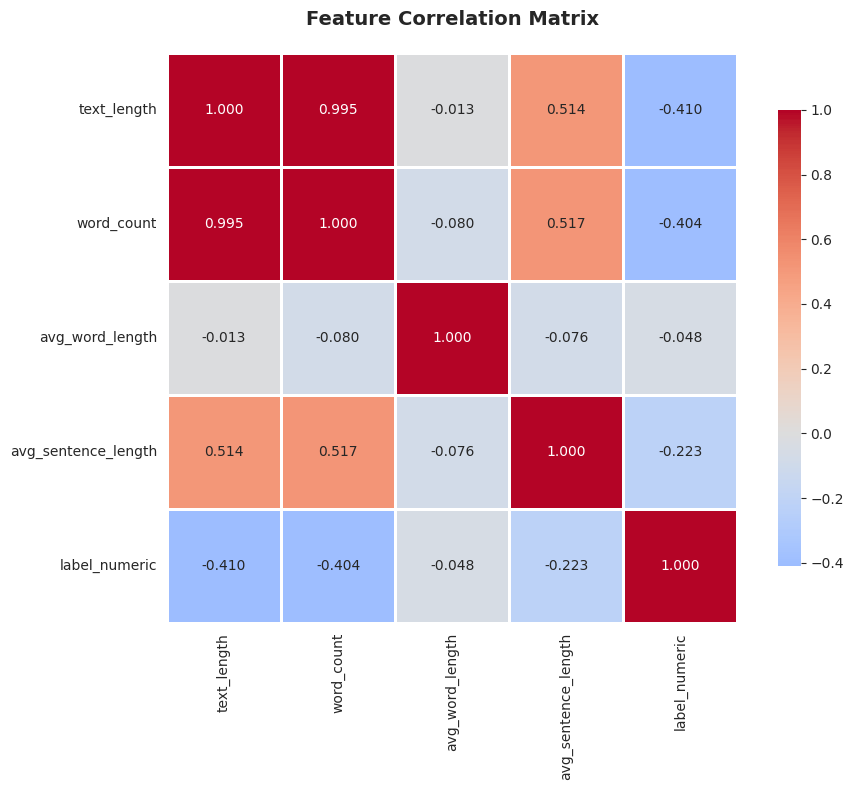


Correlation with Readability Label:
avg_word_length          : -0.048 (weak negative)
avg_sentence_length      : -0.223 (moderate negative)
word_count               : -0.404 (strong negative)
text_length              : -0.410 (strong negative)


In [10]:
# Correlation analysis
# Convert labels to numeric for correlation
label_mapping = {
    '1-Nagyon nehezen érthető': 1,
    '2-Nehezen érthető': 2,
    '3-Többé/kevésbé megértem': 3,
    '4-Érthető': 4,
    '5-Könnyen érthető': 5
}
df_labeled['label_numeric'] = df_labeled['label'].map(label_mapping)

# Calculate correlations
features = ['text_length', 'word_count', 'avg_word_length', 'avg_sentence_length', 'label_numeric']
correlation_matrix = df_labeled[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation with Readability Label:")
print("=" * 60)
label_corr = correlation_matrix['label_numeric'].drop('label_numeric').sort_values(ascending=False)
for feature, corr in label_corr.items():
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.3 else "moderate" if abs(corr) > 0.1 else "weak"
    print(f"{feature:25s}: {corr:+.3f} ({strength} {direction})")

## 5. Source Distribution Analysis

Understanding how documents are distributed across different sources.

Documents across 27 subdirectories:

Top 10 subdirectories by document count:
subdirectory
I1TLYH    278
EKGPBX    270
MDKFWC    262
Q88P3E    224
WFXBHI    188
BP17IB    176
LWVUH9    158
F0B9YK    151
SS0N7G    148
T989VT    144
Name: count, dtype: int64


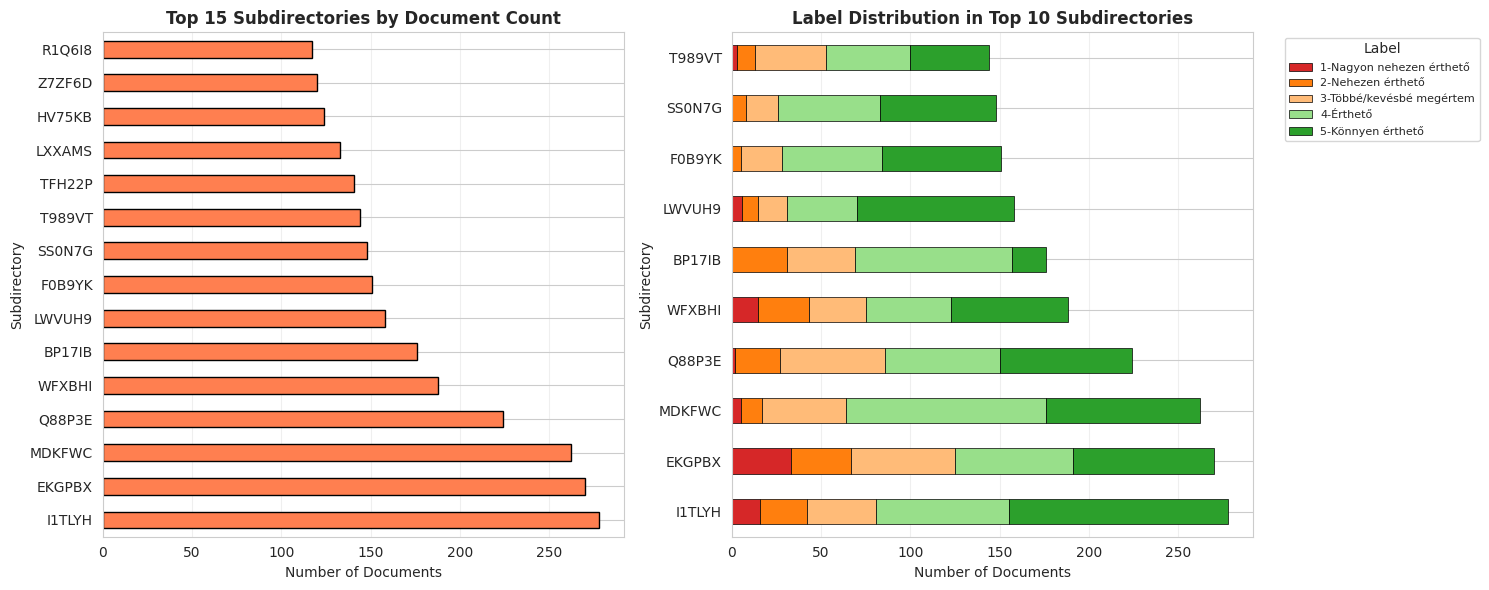

In [11]:
# Documents per subdirectory
subdir_counts = df_labeled['subdirectory'].value_counts()

print(f"Documents across {len(subdir_counts)} subdirectories:")
print("\nTop 10 subdirectories by document count:")
print(subdir_counts.head(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top subdirectories
subdir_counts.head(15).plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Top 15 Subdirectories by Document Count', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Documents')
axes[0].set_ylabel('Subdirectory')
axes[0].grid(axis='x', alpha=0.3)

# Label distribution per subdirectory (stacked)
label_by_subdir = pd.crosstab(df_labeled['subdirectory'], df_labeled['label'])
label_by_subdir_top = label_by_subdir.loc[subdir_counts.head(10).index]
label_by_subdir_top.plot(kind='barh', stacked=True, ax=axes[1], 
                          color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_title('Label Distribution in Top 10 Subdirectories', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Documents')
axes[1].set_ylabel('Subdirectory')
axes[1].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sample Text Examples

Looking at actual examples from each readability category.

In [12]:
# Show one example from each label category
print("Sample Texts by Readability Label:")
print("=" * 80)

for label in sorted(df_labeled['label'].unique()):
    sample = df_labeled[df_labeled['label'] == label].iloc[0]
    print(f"\n{label}")
    print("-" * 80)
    print(f"Source: {sample['subdirectory']}/{sample['filename']}")
    print(f"Length: {sample['text_length']} chars, {sample['word_count']} words")
    print(f"\nText: {sample['content'][:300]}..." if len(sample['content']) > 300 else f"\nText: {sample['content']}")
    print()

Sample Texts by Readability Label:

1-Nagyon nehezen érthető
--------------------------------------------------------------------------------
Source: FA0B9B/volan_aszf
Length: 951 chars, 112 words

Text: A 12.1. pontban foglalt feltételek megtartásával zárt szállítóeszközben utasonként egy kutya szállítható. A 12.1. pontban foglaltaktól eltérően, díjazás ellenében (kivéve Budapest közigazgatási határán belüli kutyaszállítás szabályaira vonatkozóan (IV. fejezet Egyéb díjak, 2. Élő állat szállításának...


2-Nehezen érthető
--------------------------------------------------------------------------------
Source: FA0B9B/volan_aszf
Length: 544 chars, 58 words

Text: Szolgáltató a közforgalmú menetrend szerinti járattal történő utazásra vonatkozó ajánlatát menetrendbe foglalja és abban teszi közzé. A közszolgáltatási szerződés alapján végzett közforgalmú menetrend szerinti járatok menetrendje az ellátásért felelőssel, mint megrendelővel (helyközi közlekedésben: ...


3-Többé/kevésbé megértem

## 7. Imputation Analysis

Understanding the quality and distribution of imputed labels.

Imputation Analysis:
Original labels: 3,374
Imputed labels: 186

Label distribution comparison:
                          Original  Imputed  Total  % Imputed
label                                                        
1-Nagyon nehezen érthető       188        0    188       0.00
2-Nehezen érthető              351       31    382       8.12
3-Többé/kevésbé megértem       686       41    727       5.64
4-Érthető                     1016       90   1106       8.14
5-Könnyen érthető             1133       24   1157       2.07


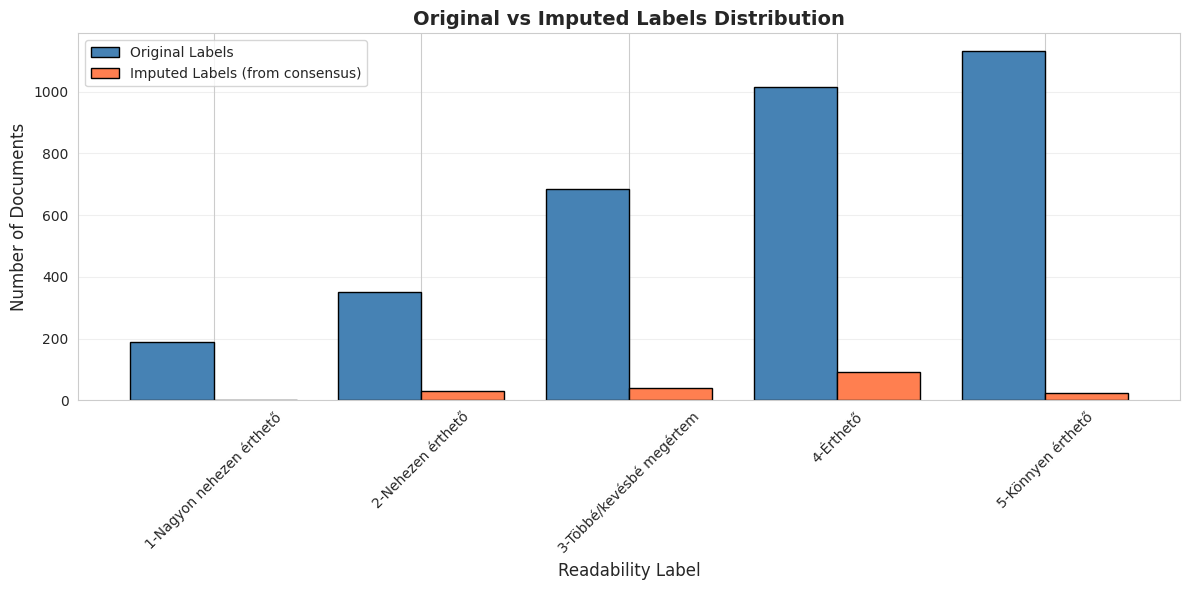

In [13]:
# Compare original vs imputed labels
print("Imputation Analysis:")
print("=" * 60)
print(f"Original labels: {(~df_labeled['is_imputed']).sum():,}")
print(f"Imputed labels: {df_labeled['is_imputed'].sum():,}")

if df_labeled['is_imputed'].sum() > 0:
    print("\nLabel distribution comparison:")
    
    comparison = pd.DataFrame({
        'Original': df_labeled[~df_labeled['is_imputed']]['label'].value_counts().sort_index(),
        'Imputed': df_labeled[df_labeled['is_imputed']]['label'].value_counts().sort_index()
    }).fillna(0).astype(int)
    
    comparison['Total'] = comparison['Original'] + comparison['Imputed']
    comparison['% Imputed'] = (comparison['Imputed'] / comparison['Total'] * 100).round(2)
    
    print(comparison)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    comparison[['Original', 'Imputed']].plot(kind='bar', ax=ax, color=['steelblue', 'coral'], 
                                              edgecolor='black', width=0.8)
    ax.set_title('Original vs Imputed Labels Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Readability Label', fontsize=12)
    ax.set_ylabel('Number of Documents', fontsize=12)
    ax.legend(['Original Labels', 'Imputed Labels (from consensus)'])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo imputed labels found in the dataset.")

## 8. Key Insights and Recommendations

Summary of findings and recommendations for modeling.

In [15]:
print("=" * 80)
print("KEY INSIGHTS FOR CLASSIFICATION MODEL")
print("=" * 80)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   • Total labeled samples: {len(df_labeled):,}")
print(f"   • Number of classes: {df_labeled['label'].nunique()}")
print(f"   • Data coverage: {len(df_labeled)/len(df)*100:.2f}% of total documents")

print("\n2. CLASS BALANCE:")
imbalance = label_counts.max() / label_counts.min()
if imbalance > 3:
    print(f"   ⚠️  Imbalanced dataset (ratio: {imbalance:.2f}:1)")
    print("   → Recommendation: Use class weights or resampling techniques")
elif imbalance > 2:
    print(f"   ⚠️  Moderately imbalanced (ratio: {imbalance:.2f}:1)")
    print("   → Recommendation: Consider using stratified sampling")
else:
    print(f"   ✓ Well-balanced dataset (ratio: {imbalance:.2f}:1)")

print("\n3. TEXT CHARACTERISTICS:")
print(f"   • Average text length: {df_labeled['text_length'].mean():.0f} characters")
print(f"   • Average word count: {df_labeled['word_count'].mean():.0f} words")
print(f"   • Average word length: {df_labeled['avg_word_length'].mean():.1f} characters")

print("\n4. FEATURE CORRELATIONS:")
strongest_corr = label_corr.abs().idxmax()
strongest_value = label_corr[strongest_corr]
print(f"   • Strongest predictor: {strongest_corr} (r={strongest_value:+.3f})")
if abs(strongest_value) < 0.2:
    print("   → Note: Weak correlations suggest complex, non-linear relationships")
    print("   → Recommendation: Use advanced NLP models (transformers, BERT)")

print("\n5. DATA QUALITY:")
if df_labeled['is_imputed'].sum() > 0:
    imputed_pct = df_labeled['is_imputed'].sum() / len(df_labeled) * 100
    print(f"   • Imputed labels: {imputed_pct:.2f}% of labeled data")
    if imputed_pct > 20:
        print("   → Recommendation: Validate model performance on original vs imputed data")
print(f"   • Unlabeled data: {df['label'].isna().sum():,} documents available for semi-supervised learning")

print("\n6. MODELING RECOMMENDATIONS:")
print("   ✓ Use stratified train-test split to maintain class distribution")
print("   ✓ Consider Hungarian language-specific preprocessing")
print("   ✓ Experiment with:")
print("      - TF-IDF + classical ML (baseline)")
print("      - Hungarian BERT models (huBERT, multilingual BERT)")
print("      - Ensemble methods for robust predictions")
print("   ✓ Use appropriate metrics: F1-score, balanced accuracy")
if imbalance > 2:
    print("   ✓ Apply class weights to handle imbalance")

print("\n" + "=" * 80)

KEY INSIGHTS FOR CLASSIFICATION MODEL

1. DATASET CHARACTERISTICS:
   • Total labeled samples: 3,560
   • Number of classes: 5
   • Data coverage: 76.38% of total documents

2. CLASS BALANCE:
   ⚠️  Imbalanced dataset (ratio: 6.15:1)
   → Recommendation: Use class weights or resampling techniques

3. TEXT CHARACTERISTICS:
   • Average text length: 387 characters
   • Average word count: 48 words
   • Average word length: 7.1 characters

4. FEATURE CORRELATIONS:
   • Strongest predictor: text_length (r=-0.410)

5. DATA QUALITY:
   • Imputed labels: 5.22% of labeled data
   • Unlabeled data: 1,101 documents available for semi-supervised learning

6. MODELING RECOMMENDATIONS:
   ✓ Use stratified train-test split to maintain class distribution
   ✓ Consider Hungarian language-specific preprocessing
   ✓ Experiment with:
      - TF-IDF + classical ML (baseline)
      - Hungarian BERT models (huBERT, multilingual BERT)
      - Ensemble methods for robust predictions
   ✓ Use appropriate metr